In [1]:
%pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 10.0 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 8.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.3/436.3 kB 8.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.9/775.9 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 2.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch, time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import manifold
from transformers import AutoModelForCausalLM, AutoTokenizer

In [3]:
model_path = "ibm-granite/granite-3b-code-base"
device = "cpu"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map=device)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 2560, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (o_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2560, out_features=10240, bias=True)
          (up_proj): Linear(in_features=2560, out_features=10240, bias=True)
          (down_proj): Linear(in_features=10240, out_features=2560, bias=True)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2560,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2560,), eps=1e-05)
      )
    )

what about this variation?

https://stackoverflow.com/questions/76051807/automodelforcausallm-for-extracting-text-embeddings

In [5]:
from pathlib import Path
def model_embeddings(prompts, model, tokenizer, cache=None):
    cfname = str(cache)
    if cache is not None:
        if Path(cfname).is_file():
            print(f"loading embeddings from cached file {cfname}")
            return torch.load(cfname)
        else:
            print(f"file {cfname} does not exist, computing embeddings")
    embeddings = []
    for p in prompts:
        input_text = str(p)

        input_tokens = tokenizer(input_text, return_tensors="pt")
        for i in input_tokens:
            input_tokens[i] = input_tokens[i].to(device)

        #print(f"{input_tokens['input_ids'].shape}")

        o = model.generate(**input_tokens,
                           max_new_tokens=1,
                           return_dict_in_generate=True,
                           output_scores=False,
                           output_hidden_states=True)

        # last hidden layer, for each of the input tokens
        lh = o.hidden_states[0][-1][0]
        # normalize each token embedding to unit length
        lh = torch.nn.functional.normalize(lh, dim=1)
        # number of input tokens
        nt = len(lh)
        # mean of the embedding vectors over the input tokens
        # some community recommend weighted average here
        lhavg = torch.sum(lh, 0) / nt
        #print(f"last: {lhavg.shape} {lhavg}")
        embeddings.append(lhavg.numpy())
    # return the list of embeddings as a tensor
    embeddings = torch.tensor(np.array(embeddings))
    if cache is not None:
        print(f"writing embeddings to cache file {cfname}")
        torch.save(embeddings, cfname)
    return embeddings

In [6]:
def cosine_dissimilarities(vecs, eps = 1e-4):
    mags = torch.norm(vecs, dim=1)
    # eps is slop for fp jitter, to keep values positive
    return (1 + eps) - torch.mm(vecs, vecs.T) / torch.outer(mags, mags)

In [7]:
from sklearn.utils import shuffle
def sample_marginals(vecs, nsamples = 10):
    vt = vecs.T
    vts = [shuffle(x, n_samples=nsamples) for x in vt]
    return torch.tensor(np.array(vts)).T

In [8]:
benchname = "mmlu-all-dev"
benchmark = pd.read_parquet(f"/opt/app-root/src/{benchname}.parquet")

In [9]:
embeddings = model_embeddings(benchmark["question"], model, tokenizer, cache = f"/opt/app-root/src/{benchname}-embeddings.pt")

loading embeddings from cached file /opt/app-root/src/mmlu-all-dev-embeddings.pt


In [10]:
insurance = [
    "when does my policy expire?",
    "does my home insurance cover flooding?",
    "where can I find my premimum for auto insurance?",
    "how do I add a car to my auto policy?",
    "can I bundle my auto and home insurance policies?",
    "what is the deductable on my umbrella policy?",
    "how can I find the contact info for my agent?",
]

In [11]:
embeddings_ins = model_embeddings(insurance, model, tokenizer, cache = "/opt/app-root/src/insurance-embeddings.pt")

loading embeddings from cached file /opt/app-root/src/insurance-embeddings.pt


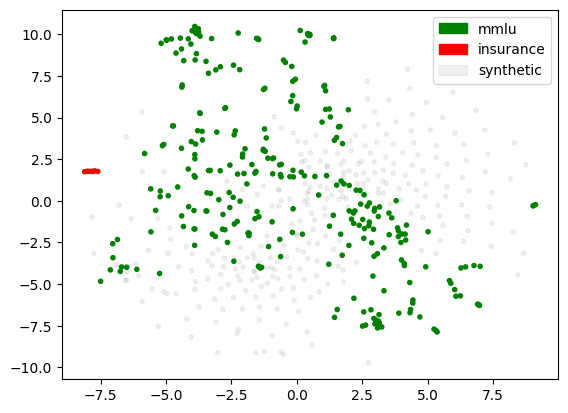

In [12]:
import matplotlib.patches as mpatches

rnd = sample_marginals(embeddings, nsamples=280)

all = torch.cat((rnd, embeddings, embeddings_ins))
colors = (['#0f0f0f0f'] * len(rnd)) + (['g'] * len(embeddings)) + (['r'] * len(embeddings_ins)) 

patches = [
    mpatches.Patch(color='g', label="mmlu"),
    mpatches.Patch(color='r', label="insurance"),
    mpatches.Patch(color='#0f0f0f0f', label="synthetic"),
]

xform = manifold.TSNE(n_components = 2, n_jobs=1, perplexity=30, metric='cosine', angle=0.3)
e2d = xform.fit(all).embedding_

x, y = e2d.transpose()
fig, ax = plt.subplots()
ax.scatter(x,y, c = colors, marker=".")
ax.legend(handles=patches)